In [49]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from tensorflow.keras import regularizers

In [51]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [52]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [53]:
tf.keras.backend.clear_session()

In [54]:
subject = 'São Paulo - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 0
train_split = split_index + 1 - 12

In [55]:
data = pd.read_csv('2003_mo_model_input_SP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,São Paulo - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,12606.426400,0.835043,0.825444,782.111,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.794676,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,12718.304862,0.835425,0.825117,789.891,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.794957,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,12824.573380,0.835806,0.824790,774.309,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.795239,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,12924.495880,0.836188,0.824463,782.071,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.795521,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,13031.542087,0.836570,0.824137,841.400,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.795802,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39560.290067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,39516.207562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,39457.198332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,39382.246174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


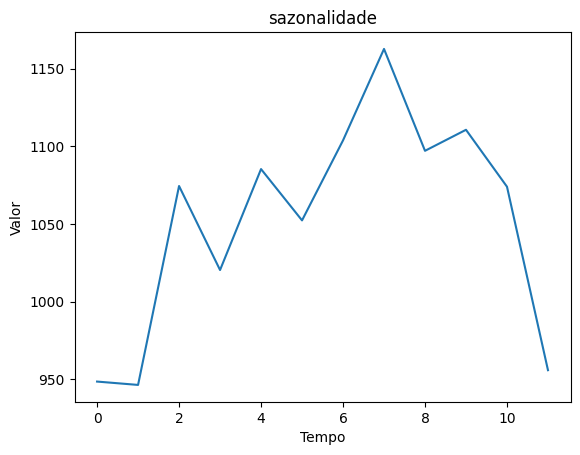

,sazonalidade
sazonalidade,
0,948.563205
1,946.405094
2,1074.415372
3,1020.345809
4,1085.308859
5,1052.289874
6,1103.779201
7,1162.634306
8,1097.065581


In [56]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [57]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,São Paulo - Consumo de Cimento (t)
0,2003-1,12606.426400,0.835043,0.825444,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.794676,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,948.563205,782.111
1,2003-2,12718.304862,0.835425,0.825117,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.794957,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,946.405094,789.891
2,2003-3,12824.573380,0.835806,0.824790,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.795239,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,1074.415372,774.309
3,2003-4,12924.495880,0.836188,0.824463,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.795521,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,1020.345809,782.071
4,2003-5,13031.542087,0.836570,0.824137,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.795802,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,1085.308859,841.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39560.290067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1085.308859,NaN
245,2023-6,39516.207562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1052.289874,NaN
246,2023-7,39457.198332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1103.779201,NaN
247,2023-8,39382.246174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1162.634306,NaN


In [58]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      656.269
1      745.154
2      788.618
3      790.169
4      791.663
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: São Paulo - Consumo de Cimento (t), Length: 249, dtype: float64

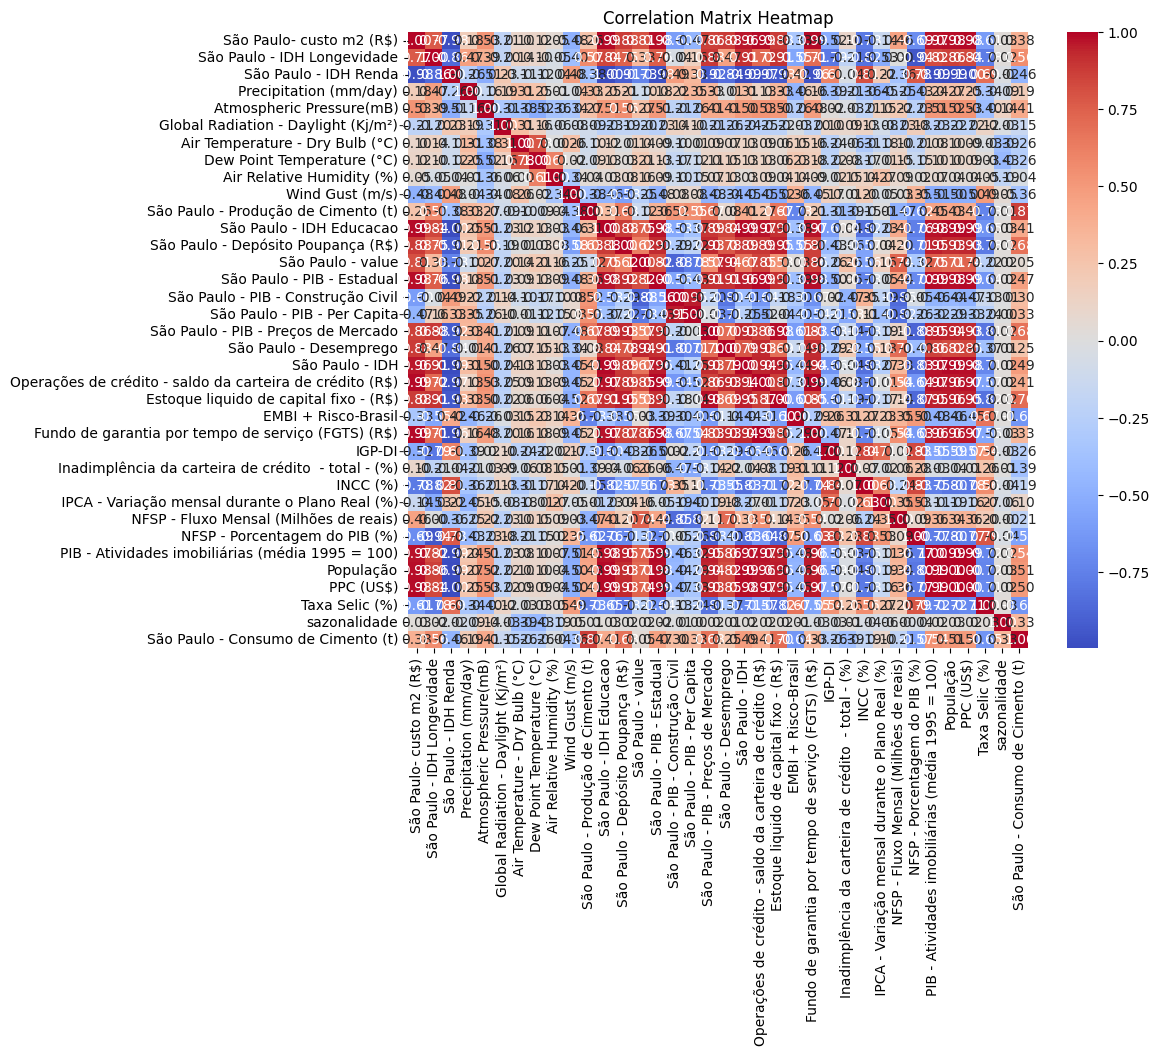

In [59]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [61]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,São Paulo- custo m2 (R$),1.116376e+05
1,São Paulo - IDH Longevidade,3.574864e+04
2,São Paulo - IDH Renda,1.812908e+08
3,Precipitation (mm/day),5.082396e+00
4,Atmospheric Pressure(mB),1.651533e+01
5,Global Radiation - Daylight (Kj/m²),4.174709e+00
6,Air Temperature - Dry Bulb (°C),6.685410e+02
7,Dew Point Temperature (°C),1.090285e+03
8,Air Relative Humidity (%),5.140547e+02
9,Wind Gust (m/s),9.837355e+00


In [62]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,12606.426400,0.835043,0.825444,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,8.310335,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,948.563205
1,12718.304862,0.835425,0.825117,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,8.304194,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,946.405094
2,12824.573380,0.835806,0.824790,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,8.298053,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,1074.415372
3,12924.495880,0.836188,0.824463,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,8.291912,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,1020.345809
4,13031.542087,0.836570,0.824137,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,8.285771,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,1085.308859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,27531.564291,0.853759,0.785144,1.649188,837.635678,1259.264356,14.381597,9.444378,75.646877,1.125921,469.950179,1.458370e+08,0.406105,1.212786e+09,4.630491e+07,11.389052,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,1162.634306
176,27630.818262,0.853505,0.785130,1.868389,836.999039,1310.279490,15.154465,10.416956,76.752779,1.129800,466.649191,1.464209e+08,0.407342,1.212582e+09,4.630199e+07,11.375100,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,1097.065581
177,27729.356714,0.853252,0.785117,1.791335,836.162555,1273.447578,15.737382,11.832353,80.433404,1.111326,466.825742,1.470048e+08,0.408466,1.212378e+09,4.629907e+07,11.361149,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,1110.594849
178,27826.924064,0.852998,0.785103,1.640566,835.659694,1266.491442,16.049727,12.619759,82.715561,1.112197,465.087743,1.475887e+08,0.409644,1.212174e+09,4.629615e+07,11.347197,3.083099e+06,7.776397e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,

In [63]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.915633,1.941338,-0.290685,0.168043,0.523863,-1.331288,-0.216635,1.280435,-0.108482,-1.519153,-1.442377,-1.162669,-1.662899,-0.566065,-0.738701,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.542892
1,-2.843323,1.913989,-0.747488,0.528527,0.633468,-1.264617,-0.852136,0.252570,0.508318,-1.549917,-1.439703,-1.088907,-1.643227,-0.540163,-0.742580,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.574896
2,-2.771012,1.886640,-1.321140,0.793270,0.654510,-1.339447,-1.207742,-0.224391,0.693259,-1.558550,-1.437030,-1.010192,-1.623554,-0.514262,-0.746458,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,0.323463
3,-2.698701,1.859291,-1.622949,1.169382,0.582307,-1.558281,-1.722465,-0.772938,0.873892,-1.571554,-1.434356,-0.939229,-1.603882,-0.488360,-0.750337,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.478375
4,-2.626390,1.831942,-2.198056,1.340585,0.605913,-1.960777,-2.188497,-1.050051,0.732680,-1.559092,-1.431683,-0.869801,-1.584210,-0.462458,-0.754215,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,0.485010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.629265,-1.430990,1.068176,1.005798,0.563222,-0.614498,-1.262532,-1.064255,-0.876820,-1.246570,0.866445,1.693135,1.280801,-1.832990,1.205700,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,1.631726
176,0.581244,-1.432108,1.813190,0.541510,0.961726,-0.006461,-0.689534,-0.852963,-0.870361,-1.274708,0.889173,1.731898,1.277427,-1.836676,1.196888,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,0.659359
177,0.533224,-1.433226,1.551304,-0.068519,0.674014,0.452135,0.144352,-0.149747,-0.901120,-1.273203,0.911901,1.767120,1.274052,-1.840362,1.188077,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,0.859995
178,0.485203,-1.434343,1.038873,-0.435245,0.619677,0.697865,0.608255,0.286280,-0.899670,-1.288018,0.934629,1.804031,1.270678,-1.844049,1.179266,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,0.316683


In [64]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.915633,1.941338,-0.290685,0.168043,0.523863,-1.331288,-0.216635,1.280435,-0.108482,-1.519153,-1.442377,-1.162669,-1.662899,-0.566065,-0.738701,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.542892
1,-2.843323,1.913989,-0.747488,0.528527,0.633468,-1.264617,-0.852136,0.252570,0.508318,-1.549917,-1.439703,-1.088907,-1.643227,-0.540163,-0.742580,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.574896
2,-2.771012,1.886640,-1.321140,0.793270,0.654510,-1.339447,-1.207742,-0.224391,0.693259,-1.558550,-1.437030,-1.010192,-1.623554,-0.514262,-0.746458,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,0.323463
3,-2.698701,1.859291,-1.622949,1.169382,0.582307,-1.558281,-1.722465,-0.772938,0.873892,-1.571554,-1.434356,-0.939229,-1.603882,-0.488360,-0.750337,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.478375
4,-2.626390,1.831942,-2.198056,1.340585,0.605913,-1.960777,-2.188497,-1.050051,0.732680,-1.559092,-1.431683,-0.869801,-1.584210,-0.462458,-0.754215,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,0.485010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.159197,-1.432572,0.308626,0.586075,-0.942525,-0.640620,-0.181570,-0.066985,-0.488793,-0.950957,0.594443,1.306111,1.294809,-1.710272,1.369417,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,1.631726
164,1.120439,-1.430691,0.413345,0.259655,0.279795,0.301879,0.397736,-0.221748,-0.520578,-0.978232,0.617024,1.340306,1.296731,-1.729655,1.349010,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,0.659359
165,1.081681,-1.428810,0.123727,0.008100,1.482705,1.323639,1.071878,-0.357777,-0.552232,-1.005176,0.639605,1.368763,1.298654,-1.749038,1.328603,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,0.859995
166,1.042924,-1.426929,-0.571047,-0.052271,2.991835,2.265210,1.450149,-0.756200,-0.577691,-1.031429,0.662186,1.397804,1.300576,-1.768421,1.308195,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,0.316683


In [65]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      656.269
1      745.154
2      788.618
3      790.169
4      791.663
        ...   
163    913.329
164    849.262
165    897.883
166    860.059
167    771.417
Name: São Paulo - Consumo de Cimento (t), Length: 168, dtype: float64

In [66]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
168,0.965409,-1.423167,-0.748161,0.132947,3.360226,2.667894,1.599332,-0.828662,-0.715322,-1.081314,0.707349,1.458396,1.304421,-1.807187,1.267380,1.376932,0.705491,0.146258,1.774331,-1.414596,1.544952,-1.619756,-1.269571,0.705135,-0.643748,1.133345,1.287235,1.337633,-0.848841,-1.542892
169,0.917388,-1.424285,-0.722758,0.237388,1.891601,1.868247,1.125626,-0.601314,-0.777474,-1.108136,0.730077,1.477068,1.301047,-1.810873,1.258569,1.372955,0.691232,0.069548,1.603011,-1.326123,1.687834,-1.703430,-1.318025,1.050348,-0.639696,1.154937,1.298856,1.349730,-0.710205,-1.574896
170,0.869368,-1.425402,-0.385802,0.545894,-0.455424,0.778763,0.491274,-0.301464,-0.847883,-1.135356,0.752805,1.502784,1.297673,-1.814559,1.249757,1.369449,0.676973,-0.001029,1.566915,-1.203988,1.921399,-1.791187,-1.274124,0.891008,-0.633632,1.176530,1.310477,1.361535,-0.663329,0.323463
171,0.821347,-1.426520,-0.672103,1.203330,-1.531543,-0.422204,-0.366936,-0.226262,-0.922314,-1.163457,0.775533,1.528612,1.294298,-1.818245,1.240946,1.367904,0.662714,-0.050763,1.509198,-1.033667,1.919191,-1.781750,-1.249228,0.718432,-0.626158,1.198123,1.322098,1.373539,-0.742310,-0.478375
172,0.773327,-1.427637,-0.942220,1.465046,-1.821232,-1.150824,-1.040005,-0.367953,-0.947771,-1.182822,0.798261,1.555232,1.290924,-1.821931,1.232134,1.363452,0.648455,-0.088103,1.510496,-0.794607,1.810466,-1.799478,-1.298144,0.870539,-0.617303,1.214047,1.333718,1.385370,-1.220021,0.485010
173,0.725306,-1.428755,-0.431026,1.868577,-1.019171,-1.370158,-1.663335,-0.946479,-0.925880,-1.214851,0.820989,1.601626,1.287550,-1.825618,1.223323,1.359511,0.634197,-0.122336,1.513850,-0.626344,1.568703,-1.782843,-1.416414,0.707986,-0.607822,1.229972,1.345339,1.397504,0.082610,-0.004653
174,0.677286,-1.429873,0.215276,1.743367,0.034834,-1.161913,-1.656496,-1.110125,-0.919236,-1.227613,0.843717,1.649697,1.284175,-1.829304,1.214511,1.352561,0.619938,-0.149882,1.502535,-0.480760,1.414649,-1.870854,-1.358337,0.499926,-0.597435,1.245897,1.356960,1.409256,-1.207352,0.758921
175,0.629265,-1.430990,1.068176,1.005798,0.563222,-0.614498,-1.262532,-1.064255,-0.876820,-1.246570,0.866445,1.693135,1.280801,-1.832990,1.205700,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,1.631726
176,0.581244,-1.432108,1.813190,0.541510,0.961726,-0.006461,-0.689534,-0.852963,-0.870361,-1.274708,0.889173,1.731898,1.277427,-1.836676,1.196888,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,0.659359
177,0.533224,-1.433226,1.551304,-0.068519,0.674014,0.452135,0.144352,-0.149747,-0.901120,-1.273203,0.911901,1.767120,1.274052,-1.840362,1.188077,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,0.859995


In [67]:
# Alvo para teste
test_target = target_data.iloc[train_split - window_size:split_index + 1]
test_target

168    860.232
169    773.607
170    790.146
171    886.929
172    941.600
173    817.301
174    957.289
175    978.990
176    906.956
177    980.948
178    872.046
179    692.232
Name: São Paulo - Consumo de Cimento (t), dtype: float64

In [68]:
# Rede neural feed-forward com optmizador Estocástico
def neural_network_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01), 
                              input_shape=(train_input.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                      train_target, 
                      epochs=10000,
                      validation_split=0.07,
                      callbacks=[early_stopping], 
                      verbose=want_verbose)
    return model, history

In [69]:
def get_a_good_seed(train_input, train_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = neural_network_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")

    return winner_seed

In [70]:
winner_seed = get_a_good_seed(train_input, train_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1357133002, 1201287533, 3554002887, 587470783, 4106040158, 3006345945, 3260949271, 1662439529, 1927073235, 1053582689]


Step: 0 ___________________________________________
val_loss: 232797.265625
winner_seed: 1357133002


Step: 1 ___________________________________________
val_loss: 370822.84375


Step: 2 ___________________________________________
val_loss: 182565.640625
winner_seed: 3554002887


Step: 3 ___________________________________________
val_loss: 396010.71875


Step: 4 ___________________________________________
val_loss: 217511.171875


Step: 5 ___________________________________________
val_loss: 179407.890625
winner_seed: 3006345945


Step: 6 ___________________________________________
val_loss: 372265.34375


Step: 7 ___________________________________________
val_loss: 426100.34375


Step: 8 ___________________________________________
val_loss: 306527.53125


Step: 9 ___________________________________________
val_loss: 113814.5390625
winner_seed: 1053582689


final_

In [71]:
trained_model, history = neural_network_model(train_input, train_target, want_verbose=1, seed=winner_seed)
# 1053582689

Epoch 1/10000
5/5 [==============================] - 0s 23ms/step - loss: 1166412.8750 - val_loss: 795242.3125
Epoch 2/10000
5/5 [==============================] - 0s 5ms/step - loss: 888890.2500 - val_loss: 1121614.2500
Epoch 3/10000
5/5 [==============================] - 0s 5ms/step - loss: 764581.1250 - val_loss: 655752.5625
Epoch 4/10000
5/5 [==============================] - 0s 5ms/step - loss: 726264.9375 - val_loss: 493565.8438
Epoch 5/10000
5/5 [==============================] - 0s 5ms/step - loss: 582517.5000 - val_loss: 549172.6250
Epoch 6/10000
5/5 [==============================] - 0s 5ms/step - loss: 570543.5625 - val_loss: 655103.6875
Epoch 7/10000
5/5 [==============================] - 0s 4ms/step - loss: 563951.4375 - val_loss: 707226.2500
Epoch 8/10000
5/5 [==============================] - 0s 5ms/step - loss: 513081.7500 - val_loss: 570496.9375
Epoch 9/10000
5/5 [==============================] - 0s 4ms/step - loss: 491510.6562 - val_loss: 579764.7500
Epoch 10/10000
5

5/5 [==============================] - 0s 4ms/step - loss: 780208.0625 - val_loss: 778494.1875
Epoch 150/10000
5/5 [==============================] - 0s 4ms/step - loss: 780702.6250 - val_loss: 777464.3125
Epoch 151/10000
5/5 [==============================] - 0s 5ms/step - loss: 777555.4375 - val_loss: 772292.6875
Epoch 152/10000
5/5 [==============================] - 0s 4ms/step - loss: 778837.0000 - val_loss: 770752.3125
Epoch 153/10000
5/5 [==============================] - 0s 5ms/step - loss: 776887.3125 - val_loss: 771135.8125
Epoch 154/10000
5/5 [==============================] - 0s 4ms/step - loss: 776453.3750 - val_loss: 774176.0000
Epoch 155/10000
5/5 [==============================] - 0s 5ms/step - loss: 774686.8750 - val_loss: 771999.6875
Epoch 156/10000
5/5 [==============================] - 0s 4ms/step - loss: 775068.6250 - val_loss: 771145.7500
Epoch 157/10000
5/5 [==============================] - 0s 4ms/step - loss: 773813.1875 - val_loss: 770554.0000
Epoch 158/10000
5

Epoch 223/10000
5/5 [==============================] - 0s 4ms/step - loss: 739783.3125 - val_loss: 740542.4375
Epoch 224/10000
5/5 [==============================] - 0s 5ms/step - loss: 738262.0625 - val_loss: 737576.4375
Epoch 225/10000
5/5 [==============================] - 0s 4ms/step - loss: 736651.0625 - val_loss: 737203.3125
Epoch 226/10000
5/5 [==============================] - 0s 4ms/step - loss: 735657.0000 - val_loss: 734403.8125
Epoch 227/10000
5/5 [==============================] - 0s 5ms/step - loss: 736873.1250 - val_loss: 735125.1875
Epoch 228/10000
5/5 [==============================] - 0s 5ms/step - loss: 735813.2500 - val_loss: 734459.8125
Epoch 229/10000
5/5 [==============================] - 0s 4ms/step - loss: 734443.8125 - val_loss: 732589.4375
Epoch 230/10000
5/5 [==============================] - 0s 4ms/step - loss: 733605.5625 - val_loss: 734309.6875
Epoch 231/10000
5/5 [==============================] - 0s 4ms/step - loss: 732870.6250 - val_loss: 733520.8125
E

Epoch 297/10000
5/5 [==============================] - 0s 5ms/step - loss: 692793.8750 - val_loss: 692953.1875
Epoch 298/10000
5/5 [==============================] - 0s 5ms/step - loss: 690980.3125 - val_loss: 691793.6875
Epoch 299/10000
5/5 [==============================] - 0s 5ms/step - loss: 690327.2500 - val_loss: 691270.3125
Epoch 300/10000
5/5 [==============================] - 0s 5ms/step - loss: 689748.8125 - val_loss: 690419.6250
Epoch 301/10000
5/5 [==============================] - 0s 5ms/step - loss: 688649.3125 - val_loss: 689115.9375
Epoch 302/10000
5/5 [==============================] - 0s 5ms/step - loss: 688175.6250 - val_loss: 688215.5000
Epoch 303/10000
5/5 [==============================] - 0s 5ms/step - loss: 687372.0000 - val_loss: 687694.3125
Epoch 304/10000
5/5 [==============================] - 0s 5ms/step - loss: 686074.2500 - val_loss: 686841.7500
Epoch 305/10000
5/5 [==============================] - 0s 5ms/step - loss: 686322.9375 - val_loss: 685717.6875
E

Epoch 371/10000
5/5 [==============================] - 0s 5ms/step - loss: 652635.5625 - val_loss: 651632.5000
Epoch 372/10000
5/5 [==============================] - 0s 5ms/step - loss: 652790.8125 - val_loss: 651335.7500
Epoch 373/10000
5/5 [==============================] - 0s 5ms/step - loss: 651736.2500 - val_loss: 650406.7500
Epoch 374/10000
5/5 [==============================] - 0s 5ms/step - loss: 651314.7500 - val_loss: 650105.8750
Epoch 375/10000
5/5 [==============================] - 0s 5ms/step - loss: 650554.1875 - val_loss: 648788.8750
Epoch 376/10000
5/5 [==============================] - 0s 5ms/step - loss: 649668.7500 - val_loss: 648633.3125
Epoch 377/10000
5/5 [==============================] - 0s 6ms/step - loss: 648663.2500 - val_loss: 647539.0625
Epoch 378/10000
5/5 [==============================] - 0s 5ms/step - loss: 647660.6875 - val_loss: 648596.8750
Epoch 379/10000
5/5 [==============================] - 0s 5ms/step - loss: 648018.5625 - val_loss: 648356.8750
E

Epoch 445/10000
5/5 [==============================] - 0s 5ms/step - loss: 608236.3125 - val_loss: 608317.0000
Epoch 446/10000
5/5 [==============================] - 0s 5ms/step - loss: 608028.1250 - val_loss: 607970.3125
Epoch 447/10000
5/5 [==============================] - 0s 5ms/step - loss: 607834.1250 - val_loss: 607203.1875
Epoch 448/10000
5/5 [==============================] - 0s 5ms/step - loss: 607018.1250 - val_loss: 606641.3750
Epoch 449/10000
5/5 [==============================] - 0s 5ms/step - loss: 606489.1875 - val_loss: 605827.8125
Epoch 450/10000
5/5 [==============================] - 0s 5ms/step - loss: 605153.0625 - val_loss: 604817.9375
Epoch 451/10000
5/5 [==============================] - 0s 5ms/step - loss: 605241.3125 - val_loss: 604508.5000
Epoch 452/10000
5/5 [==============================] - 0s 5ms/step - loss: 604821.3125 - val_loss: 603524.9375
Epoch 453/10000
5/5 [==============================] - 0s 5ms/step - loss: 603611.9375 - val_loss: 603886.4375
E

Epoch 519/10000
5/5 [==============================] - 0s 5ms/step - loss: 567909.2500 - val_loss: 566905.5000
Epoch 520/10000
5/5 [==============================] - 0s 5ms/step - loss: 567424.6250 - val_loss: 566562.6875
Epoch 521/10000
5/5 [==============================] - 0s 5ms/step - loss: 566815.5625 - val_loss: 565953.9375
Epoch 522/10000
5/5 [==============================] - 0s 5ms/step - loss: 566124.9375 - val_loss: 565497.3750
Epoch 523/10000
5/5 [==============================] - 0s 5ms/step - loss: 564709.1875 - val_loss: 564952.3125
Epoch 524/10000
5/5 [==============================] - 0s 5ms/step - loss: 564989.0000 - val_loss: 564576.9375
Epoch 525/10000
5/5 [==============================] - 0s 5ms/step - loss: 564111.3750 - val_loss: 564261.5000
Epoch 526/10000
5/5 [==============================] - 0s 5ms/step - loss: 565064.1250 - val_loss: 563686.1875
Epoch 527/10000
5/5 [==============================] - 0s 5ms/step - loss: 563187.3125 - val_loss: 562982.6875
E

Epoch 593/10000
5/5 [==============================] - 0s 5ms/step - loss: 532839.5625 - val_loss: 532515.0000
Epoch 594/10000
5/5 [==============================] - 0s 5ms/step - loss: 532491.0625 - val_loss: 531986.9375
Epoch 595/10000
5/5 [==============================] - 0s 5ms/step - loss: 533263.6875 - val_loss: 530983.6250
Epoch 596/10000
5/5 [==============================] - 0s 5ms/step - loss: 530904.3750 - val_loss: 530499.6250
Epoch 597/10000
5/5 [==============================] - 0s 5ms/step - loss: 530768.4375 - val_loss: 529873.4375
Epoch 598/10000
5/5 [==============================] - 0s 6ms/step - loss: 530481.4375 - val_loss: 529435.3750
Epoch 599/10000
5/5 [==============================] - 0s 5ms/step - loss: 529624.1250 - val_loss: 529139.8750
Epoch 600/10000
5/5 [==============================] - 0s 5ms/step - loss: 529111.4375 - val_loss: 528120.9375
Epoch 601/10000
5/5 [==============================] - 0s 6ms/step - loss: 529111.6250 - val_loss: 527595.5000
E

Epoch 667/10000
5/5 [==============================] - 0s 5ms/step - loss: 499468.7812 - val_loss: 499258.2812
Epoch 668/10000
5/5 [==============================] - 0s 5ms/step - loss: 498989.5938 - val_loss: 498499.1562
Epoch 669/10000
5/5 [==============================] - 0s 5ms/step - loss: 499461.9375 - val_loss: 498196.1562
Epoch 670/10000
5/5 [==============================] - 0s 5ms/step - loss: 497662.3438 - val_loss: 497275.8750
Epoch 671/10000
5/5 [==============================] - 0s 5ms/step - loss: 496804.8125 - val_loss: 496565.5938
Epoch 672/10000
5/5 [==============================] - 0s 5ms/step - loss: 496670.2500 - val_loss: 496108.4062
Epoch 673/10000
5/5 [==============================] - 0s 5ms/step - loss: 496524.4688 - val_loss: 494955.8438
Epoch 674/10000
5/5 [==============================] - 0s 5ms/step - loss: 496371.9062 - val_loss: 494284.1250
Epoch 675/10000
5/5 [==============================] - 0s 5ms/step - loss: 495641.3750 - val_loss: 493834.6562
E

Epoch 741/10000
5/5 [==============================] - 0s 5ms/step - loss: 465530.0000 - val_loss: 462937.2500
Epoch 742/10000
5/5 [==============================] - 0s 5ms/step - loss: 464993.8438 - val_loss: 461999.7500
Epoch 743/10000
5/5 [==============================] - 0s 5ms/step - loss: 463685.5312 - val_loss: 460865.5000
Epoch 744/10000
5/5 [==============================] - 0s 5ms/step - loss: 463532.5625 - val_loss: 461667.6562
Epoch 745/10000
5/5 [==============================] - 0s 5ms/step - loss: 463337.7500 - val_loss: 461204.2812
Epoch 746/10000
5/5 [==============================] - 0s 5ms/step - loss: 462867.9375 - val_loss: 460761.5312
Epoch 747/10000
5/5 [==============================] - 0s 5ms/step - loss: 461972.7188 - val_loss: 460985.5938
Epoch 748/10000
5/5 [==============================] - 0s 5ms/step - loss: 461847.9375 - val_loss: 460646.0000
Epoch 749/10000
5/5 [==============================] - 0s 5ms/step - loss: 460836.7188 - val_loss: 459325.0000
E

Epoch 815/10000
5/5 [==============================] - 0s 5ms/step - loss: 434745.9375 - val_loss: 436972.1250
Epoch 816/10000
5/5 [==============================] - 0s 5ms/step - loss: 434189.3438 - val_loss: 436917.4688
Epoch 817/10000
5/5 [==============================] - 0s 5ms/step - loss: 434196.3125 - val_loss: 436209.0000
Epoch 818/10000
5/5 [==============================] - 0s 5ms/step - loss: 432908.0000 - val_loss: 435954.1250
Epoch 819/10000
5/5 [==============================] - 0s 5ms/step - loss: 432738.7812 - val_loss: 434716.3750
Epoch 820/10000
5/5 [==============================] - 0s 5ms/step - loss: 431904.3438 - val_loss: 434057.3438
Epoch 821/10000
5/5 [==============================] - 0s 5ms/step - loss: 431688.8125 - val_loss: 431642.4688
Epoch 822/10000
5/5 [==============================] - 0s 5ms/step - loss: 430794.0938 - val_loss: 430739.7500
Epoch 823/10000
5/5 [==============================] - 0s 5ms/step - loss: 431362.0938 - val_loss: 430084.8750
E

Epoch 889/10000
5/5 [==============================] - 0s 5ms/step - loss: 406699.0312 - val_loss: 403974.9688
Epoch 890/10000
5/5 [==============================] - 0s 5ms/step - loss: 406158.1875 - val_loss: 403545.3438
Epoch 891/10000
5/5 [==============================] - 0s 5ms/step - loss: 405688.9688 - val_loss: 404446.9062
Epoch 892/10000
5/5 [==============================] - 0s 6ms/step - loss: 406589.4375 - val_loss: 404492.7188
Epoch 893/10000
5/5 [==============================] - 0s 5ms/step - loss: 405358.0938 - val_loss: 404729.7812
Epoch 894/10000
5/5 [==============================] - 0s 5ms/step - loss: 404419.4375 - val_loss: 403588.3438
Epoch 895/10000
5/5 [==============================] - 0s 5ms/step - loss: 404785.4375 - val_loss: 403199.0312
Epoch 896/10000
5/5 [==============================] - 0s 5ms/step - loss: 403611.7188 - val_loss: 402964.4062
Epoch 897/10000
5/5 [==============================] - 0s 5ms/step - loss: 403686.0938 - val_loss: 402406.1562
E

Epoch 963/10000
5/5 [==============================] - 0s 6ms/step - loss: 379936.1250 - val_loss: 378078.3438
Epoch 964/10000
5/5 [==============================] - 0s 5ms/step - loss: 379872.4688 - val_loss: 377607.9688
Epoch 965/10000
5/5 [==============================] - 0s 5ms/step - loss: 378880.8125 - val_loss: 377206.7188
Epoch 966/10000
5/5 [==============================] - 0s 5ms/step - loss: 379378.5938 - val_loss: 376984.2812
Epoch 967/10000
5/5 [==============================] - 0s 5ms/step - loss: 377987.8125 - val_loss: 376535.1562
Epoch 968/10000
5/5 [==============================] - 0s 5ms/step - loss: 378128.2500 - val_loss: 376977.2812
Epoch 969/10000
5/5 [==============================] - 0s 5ms/step - loss: 378031.5000 - val_loss: 376759.3750
Epoch 970/10000
5/5 [==============================] - 0s 5ms/step - loss: 377486.5938 - val_loss: 377023.1562
Epoch 971/10000
5/5 [==============================] - 0s 5ms/step - loss: 376998.5000 - val_loss: 376999.9688
E

5/5 [==============================] - 0s 5ms/step - loss: 340365.0312 - val_loss: 340123.5312
Epoch 1110/10000
5/5 [==============================] - 0s 5ms/step - loss: 340545.1875 - val_loss: 339915.7500
Epoch 1111/10000
5/5 [==============================] - 0s 5ms/step - loss: 340203.2188 - val_loss: 339388.7188
Epoch 1112/10000
5/5 [==============================] - 0s 5ms/step - loss: 339154.7812 - val_loss: 339022.6875
Epoch 1113/10000
5/5 [==============================] - 0s 5ms/step - loss: 339824.4062 - val_loss: 338596.6875
Epoch 1114/10000
5/5 [==============================] - 0s 5ms/step - loss: 338656.6562 - val_loss: 338340.5625
Epoch 1115/10000
5/5 [==============================] - 0s 5ms/step - loss: 338349.3125 - val_loss: 338192.4062
Epoch 1116/10000
5/5 [==============================] - 0s 5ms/step - loss: 338397.9375 - val_loss: 337611.5938
Epoch 1117/10000
5/5 [==============================] - 0s 5ms/step - loss: 337664.9688 - val_loss: 336895.5312
Epoch 111

5/5 [==============================] - 0s 5ms/step - loss: 299745.3750 - val_loss: 298990.5625
Epoch 1256/10000
5/5 [==============================] - 0s 5ms/step - loss: 300308.2812 - val_loss: 298769.2500
Epoch 1257/10000
5/5 [==============================] - 0s 5ms/step - loss: 299629.8438 - val_loss: 298044.0938
Epoch 1258/10000
5/5 [==============================] - 0s 6ms/step - loss: 299782.8750 - val_loss: 297957.2812
Epoch 1259/10000
5/5 [==============================] - 0s 5ms/step - loss: 299011.0625 - val_loss: 297382.8750
Epoch 1260/10000
5/5 [==============================] - 0s 5ms/step - loss: 298739.8750 - val_loss: 296942.8750
Epoch 1261/10000
5/5 [==============================] - 0s 5ms/step - loss: 298630.2188 - val_loss: 296873.1875
Epoch 1262/10000
5/5 [==============================] - 0s 5ms/step - loss: 297341.1875 - val_loss: 295139.0625
Epoch 1263/10000
5/5 [==============================] - 0s 5ms/step - loss: 297528.8750 - val_loss: 297823.5625
Epoch 126

5/5 [==============================] - 0s 5ms/step - loss: 260677.5156 - val_loss: 260614.4531
Epoch 1402/10000
5/5 [==============================] - 0s 5ms/step - loss: 261481.3906 - val_loss: 260436.4531
Epoch 1403/10000
5/5 [==============================] - 0s 5ms/step - loss: 261108.6875 - val_loss: 260054.6719
Epoch 1404/10000
5/5 [==============================] - 0s 5ms/step - loss: 260911.6719 - val_loss: 259856.9531
Epoch 1405/10000
5/5 [==============================] - 0s 5ms/step - loss: 260273.3281 - val_loss: 259265.1250
Epoch 1406/10000
5/5 [==============================] - 0s 5ms/step - loss: 262029.0469 - val_loss: 263737.4375
Epoch 1407/10000
5/5 [==============================] - 0s 5ms/step - loss: 262184.9375 - val_loss: 261783.3906
Epoch 1408/10000
5/5 [==============================] - 0s 5ms/step - loss: 262951.0938 - val_loss: 262413.3750
Epoch 1409/10000
5/5 [==============================] - 0s 5ms/step - loss: 262569.6562 - val_loss: 262091.1719
Epoch 141

5/5 [==============================] - 0s 5ms/step - loss: 231027.8906 - val_loss: 230607.4531
Epoch 1548/10000
5/5 [==============================] - 0s 5ms/step - loss: 230617.6875 - val_loss: 229932.1094
Epoch 1549/10000
5/5 [==============================] - 0s 5ms/step - loss: 230239.9531 - val_loss: 230523.3125
Epoch 1550/10000
5/5 [==============================] - 0s 5ms/step - loss: 230267.2344 - val_loss: 229861.4219
Epoch 1551/10000
5/5 [==============================] - 0s 5ms/step - loss: 229724.8750 - val_loss: 229659.2969
Epoch 1552/10000
5/5 [==============================] - 0s 5ms/step - loss: 229482.9688 - val_loss: 229407.2344
Epoch 1553/10000
5/5 [==============================] - 0s 5ms/step - loss: 229790.3906 - val_loss: 228772.4531
Epoch 1554/10000
5/5 [==============================] - 0s 5ms/step - loss: 229920.3125 - val_loss: 228551.0781
Epoch 1555/10000
5/5 [==============================] - 0s 5ms/step - loss: 229245.8906 - val_loss: 228962.1875
Epoch 155

5/5 [==============================] - 0s 5ms/step - loss: 204813.8281 - val_loss: 203433.6406
Epoch 1694/10000
5/5 [==============================] - 0s 5ms/step - loss: 204894.2656 - val_loss: 203907.1875
Epoch 1695/10000
5/5 [==============================] - 0s 5ms/step - loss: 204428.7500 - val_loss: 202682.3750
Epoch 1696/10000
5/5 [==============================] - 0s 5ms/step - loss: 204203.0312 - val_loss: 202638.1875
Epoch 1697/10000
5/5 [==============================] - 0s 5ms/step - loss: 203757.3438 - val_loss: 202752.2500
Epoch 1698/10000
5/5 [==============================] - 0s 5ms/step - loss: 204600.0156 - val_loss: 202696.5000
Epoch 1699/10000
5/5 [==============================] - 0s 5ms/step - loss: 202857.2500 - val_loss: 202504.3594
Epoch 1700/10000
5/5 [==============================] - 0s 5ms/step - loss: 203202.6250 - val_loss: 202184.5781
Epoch 1701/10000
5/5 [==============================] - 0s 6ms/step - loss: 203754.8281 - val_loss: 202158.0000
Epoch 170

5/5 [==============================] - 0s 6ms/step - loss: 196385.3281 - val_loss: 198271.5000
Epoch 1840/10000
5/5 [==============================] - 0s 5ms/step - loss: 196154.0938 - val_loss: 202889.8281
Epoch 1841/10000
5/5 [==============================] - 0s 5ms/step - loss: 195121.9219 - val_loss: 199077.9531
Epoch 1842/10000
5/5 [==============================] - 0s 5ms/step - loss: 196580.3594 - val_loss: 201940.8125
Epoch 1843/10000
5/5 [==============================] - 0s 5ms/step - loss: 195365.7031 - val_loss: 192559.2656
Epoch 1844/10000
5/5 [==============================] - 0s 5ms/step - loss: 193390.3125 - val_loss: 192470.1250
Epoch 1845/10000
5/5 [==============================] - 0s 6ms/step - loss: 193777.8594 - val_loss: 192313.1875
Epoch 1846/10000
5/5 [==============================] - 0s 5ms/step - loss: 193554.0156 - val_loss: 192033.9375
Epoch 1847/10000
5/5 [==============================] - 0s 5ms/step - loss: 192773.9844 - val_loss: 191956.4531
Epoch 184

5/5 [==============================] - 0s 5ms/step - loss: 192033.4375 - val_loss: 189226.8594
Epoch 1986/10000
5/5 [==============================] - 0s 5ms/step - loss: 192064.3906 - val_loss: 188998.0156
Epoch 1987/10000
5/5 [==============================] - 0s 5ms/step - loss: 193153.3125 - val_loss: 194528.5000
Epoch 1988/10000
5/5 [==============================] - 0s 5ms/step - loss: 192076.4219 - val_loss: 194202.4219
Epoch 1989/10000
5/5 [==============================] - 0s 5ms/step - loss: 193134.9688 - val_loss: 187548.2969
Epoch 1990/10000
5/5 [==============================] - 0s 5ms/step - loss: 193173.4844 - val_loss: 190142.4219
Epoch 1991/10000
5/5 [==============================] - 0s 5ms/step - loss: 191319.7031 - val_loss: 188438.8594
Epoch 1992/10000
5/5 [==============================] - 0s 5ms/step - loss: 192237.8281 - val_loss: 190350.5156
Epoch 1993/10000
5/5 [==============================] - 0s 5ms/step - loss: 192716.6250 - val_loss: 205525.6719
Epoch 199

5/5 [==============================] - 0s 5ms/step - loss: 198808.5156 - val_loss: 212026.4375
Epoch 2132/10000
5/5 [==============================] - 0s 5ms/step - loss: 198198.7969 - val_loss: 212626.4219
Epoch 2133/10000
5/5 [==============================] - 0s 5ms/step - loss: 196919.2500 - val_loss: 211390.0469
Epoch 2134/10000
5/5 [==============================] - 0s 5ms/step - loss: 199885.1562 - val_loss: 200186.3594
Epoch 2135/10000
5/5 [==============================] - 0s 5ms/step - loss: 196990.3906 - val_loss: 193062.6719
Epoch 2136/10000
5/5 [==============================] - 0s 5ms/step - loss: 196240.7656 - val_loss: 193845.5469
Epoch 2137/10000
5/5 [==============================] - 0s 6ms/step - loss: 194917.7500 - val_loss: 196094.3594
Epoch 2138/10000
5/5 [==============================] - 0s 6ms/step - loss: 197746.8750 - val_loss: 204834.4219
Epoch 2139/10000
5/5 [==============================] - 0s 5ms/step - loss: 198476.4688 - val_loss: 236793.6719
Epoch 214

5/5 [==============================] - 0s 5ms/step - loss: 200257.7500 - val_loss: 217133.2031
Epoch 2278/10000
5/5 [==============================] - 0s 5ms/step - loss: 199794.3594 - val_loss: 218186.5000
Epoch 2279/10000
5/5 [==============================] - 0s 5ms/step - loss: 199903.1719 - val_loss: 217305.3750
Epoch 2280/10000
5/5 [==============================] - 0s 5ms/step - loss: 199503.8281 - val_loss: 216368.8125
Epoch 2281/10000
5/5 [==============================] - 0s 5ms/step - loss: 199969.4219 - val_loss: 215255.7344
Epoch 2282/10000
5/5 [==============================] - 0s 5ms/step - loss: 199887.6094 - val_loss: 218118.8125
Epoch 2283/10000
5/5 [==============================] - 0s 5ms/step - loss: 198593.1250 - val_loss: 215722.0625
Epoch 2284/10000
5/5 [==============================] - 0s 5ms/step - loss: 198640.1875 - val_loss: 213590.8906
Epoch 2285/10000
5/5 [==============================] - 0s 5ms/step - loss: 198135.3281 - val_loss: 215039.3281
Epoch 228

5/5 [==============================] - 0s 6ms/step - loss: 185007.0781 - val_loss: 181171.2500
Epoch 2424/10000
5/5 [==============================] - 0s 6ms/step - loss: 181680.1875 - val_loss: 182596.4844
Epoch 2425/10000
5/5 [==============================] - 0s 5ms/step - loss: 182023.8281 - val_loss: 183181.9375
Epoch 2426/10000
5/5 [==============================] - 0s 5ms/step - loss: 182360.3594 - val_loss: 220558.1719
Epoch 2427/10000
5/5 [==============================] - 0s 5ms/step - loss: 187165.0938 - val_loss: 202778.6250
Epoch 2428/10000
5/5 [==============================] - 0s 5ms/step - loss: 187032.9688 - val_loss: 200631.7031
Epoch 2429/10000
5/5 [==============================] - 0s 5ms/step - loss: 184790.2031 - val_loss: 198534.5781
Epoch 2430/10000
5/5 [==============================] - 0s 5ms/step - loss: 184841.5625 - val_loss: 192644.9375
Epoch 2431/10000
5/5 [==============================] - 0s 5ms/step - loss: 182307.6719 - val_loss: 186177.0625
Epoch 243

5/5 [==============================] - 0s 5ms/step - loss: 162945.1875 - val_loss: 162113.9531
Epoch 2570/10000
5/5 [==============================] - 0s 5ms/step - loss: 162734.5000 - val_loss: 161966.9688
Epoch 2571/10000
5/5 [==============================] - 0s 5ms/step - loss: 161915.2031 - val_loss: 161748.6094
Epoch 2572/10000
5/5 [==============================] - 0s 5ms/step - loss: 162357.8281 - val_loss: 161658.1250
Epoch 2573/10000
5/5 [==============================] - 0s 5ms/step - loss: 161890.8125 - val_loss: 161730.8125
Epoch 2574/10000
5/5 [==============================] - 0s 5ms/step - loss: 161894.0781 - val_loss: 161683.5000
Epoch 2575/10000
5/5 [==============================] - 0s 5ms/step - loss: 161640.8281 - val_loss: 161378.9844
Epoch 2576/10000
5/5 [==============================] - 0s 5ms/step - loss: 161012.6562 - val_loss: 161108.0000
Epoch 2577/10000
5/5 [==============================] - 0s 5ms/step - loss: 161600.1719 - val_loss: 160952.6406
Epoch 257

5/5 [==============================] - 0s 5ms/step - loss: 152339.1875 - val_loss: 151583.7344
Epoch 2716/10000
5/5 [==============================] - 0s 5ms/step - loss: 153174.4688 - val_loss: 151538.6875
Epoch 2717/10000
5/5 [==============================] - 0s 5ms/step - loss: 152689.6719 - val_loss: 151480.7500
Epoch 2718/10000
5/5 [==============================] - 0s 5ms/step - loss: 152156.1250 - val_loss: 151133.3281
Epoch 2719/10000
5/5 [==============================] - 0s 5ms/step - loss: 151425.8594 - val_loss: 151296.4531
Epoch 2720/10000
5/5 [==============================] - 0s 5ms/step - loss: 152403.0312 - val_loss: 150935.4375
Epoch 2721/10000
5/5 [==============================] - 0s 5ms/step - loss: 152262.0156 - val_loss: 150743.7656
Epoch 2722/10000
5/5 [==============================] - 0s 5ms/step - loss: 152667.6094 - val_loss: 151738.7656
Epoch 2723/10000
5/5 [==============================] - 0s 5ms/step - loss: 151588.2344 - val_loss: 151257.8750
Epoch 272

5/5 [==============================] - 0s 5ms/step - loss: 155170.1094 - val_loss: 159773.5625
Epoch 2862/10000
5/5 [==============================] - 0s 5ms/step - loss: 155833.7812 - val_loss: 161152.4375
Epoch 2863/10000
5/5 [==============================] - 0s 5ms/step - loss: 154728.6094 - val_loss: 159724.8594
Epoch 2864/10000
5/5 [==============================] - 0s 5ms/step - loss: 154736.8906 - val_loss: 161664.1406
Epoch 2865/10000
5/5 [==============================] - 0s 5ms/step - loss: 153580.3281 - val_loss: 159909.8906
Epoch 2866/10000
5/5 [==============================] - 0s 5ms/step - loss: 153836.2031 - val_loss: 159077.6250
Epoch 2867/10000
5/5 [==============================] - 0s 5ms/step - loss: 152525.0469 - val_loss: 159017.5781
Epoch 2868/10000
5/5 [==============================] - 0s 5ms/step - loss: 152366.1094 - val_loss: 157911.3906
Epoch 2869/10000
5/5 [==============================] - 0s 5ms/step - loss: 151213.6719 - val_loss: 159158.3438
Epoch 287

5/5 [==============================] - 0s 5ms/step - loss: 140857.2344 - val_loss: 141806.8281
Epoch 3008/10000
5/5 [==============================] - 0s 5ms/step - loss: 141361.5938 - val_loss: 151419.6875
Epoch 3009/10000
5/5 [==============================] - 0s 6ms/step - loss: 142017.1094 - val_loss: 149183.3750
Epoch 3010/10000
5/5 [==============================] - 0s 5ms/step - loss: 142177.5781 - val_loss: 149374.6406
Epoch 3011/10000
5/5 [==============================] - 0s 5ms/step - loss: 141346.2188 - val_loss: 149395.8281
Epoch 3012/10000
5/5 [==============================] - 0s 5ms/step - loss: 141164.6875 - val_loss: 149415.7500
Epoch 3013/10000
5/5 [==============================] - 0s 5ms/step - loss: 142481.9531 - val_loss: 146519.6250
Epoch 3014/10000
5/5 [==============================] - 0s 5ms/step - loss: 140995.5156 - val_loss: 145568.5156
Epoch 3015/10000
5/5 [==============================] - 0s 5ms/step - loss: 140754.0000 - val_loss: 145271.0156
Epoch 301

5/5 [==============================] - 0s 5ms/step - loss: 147084.3281 - val_loss: 146671.0938
Epoch 3154/10000
5/5 [==============================] - 0s 5ms/step - loss: 146160.8125 - val_loss: 146991.9219
Epoch 3155/10000
5/5 [==============================] - 0s 5ms/step - loss: 146685.5312 - val_loss: 146733.5781
Epoch 3156/10000
5/5 [==============================] - 0s 5ms/step - loss: 147244.3594 - val_loss: 151723.8438
Epoch 3157/10000
5/5 [==============================] - 0s 5ms/step - loss: 146950.3594 - val_loss: 154202.5469
Epoch 3158/10000
5/5 [==============================] - 0s 6ms/step - loss: 146835.2969 - val_loss: 152136.9688
Epoch 3159/10000
5/5 [==============================] - 0s 5ms/step - loss: 146830.5156 - val_loss: 152539.0000
Epoch 3160/10000
5/5 [==============================] - 0s 5ms/step - loss: 146414.8906 - val_loss: 145272.6094
Epoch 3161/10000
5/5 [==============================] - 0s 6ms/step - loss: 145599.4531 - val_loss: 146429.7500
Epoch 316

5/5 [==============================] - 0s 5ms/step - loss: 136472.0312 - val_loss: 136363.2969
Epoch 3300/10000
5/5 [==============================] - 0s 5ms/step - loss: 139654.3281 - val_loss: 139932.4219
Epoch 3301/10000
5/5 [==============================] - 0s 5ms/step - loss: 137464.8750 - val_loss: 140923.5938
Epoch 3302/10000
5/5 [==============================] - 0s 5ms/step - loss: 136339.1719 - val_loss: 139306.6250
Epoch 3303/10000
5/5 [==============================] - 0s 5ms/step - loss: 135980.5000 - val_loss: 137897.2969
Epoch 3304/10000
5/5 [==============================] - 0s 5ms/step - loss: 136112.7344 - val_loss: 146690.0000
Epoch 3305/10000
5/5 [==============================] - 0s 5ms/step - loss: 137246.3906 - val_loss: 145267.9219
Epoch 3306/10000
5/5 [==============================] - 0s 5ms/step - loss: 136862.5781 - val_loss: 145475.6719
Epoch 3307/10000
5/5 [==============================] - 0s 5ms/step - loss: 136764.2500 - val_loss: 143444.8594
Epoch 330

5/5 [==============================] - 0s 5ms/step - loss: 121515.7188 - val_loss: 127989.7734
Epoch 3446/10000
5/5 [==============================] - 0s 5ms/step - loss: 121732.0781 - val_loss: 125730.6328
Epoch 3447/10000
5/5 [==============================] - 0s 5ms/step - loss: 121916.3438 - val_loss: 124817.6953
Epoch 3448/10000
5/5 [==============================] - 0s 5ms/step - loss: 120525.1250 - val_loss: 124242.2500
Epoch 3449/10000
5/5 [==============================] - 0s 5ms/step - loss: 122340.3047 - val_loss: 123666.8984
Epoch 3450/10000
5/5 [==============================] - 0s 6ms/step - loss: 120451.3203 - val_loss: 123270.9766
Epoch 3451/10000
5/5 [==============================] - 0s 5ms/step - loss: 120206.2656 - val_loss: 122479.1484
Epoch 3452/10000
5/5 [==============================] - 0s 5ms/step - loss: 119635.2656 - val_loss: 122991.2734
Epoch 3453/10000
5/5 [==============================] - 0s 5ms/step - loss: 120409.2578 - val_loss: 123283.6484
Epoch 345

5/5 [==============================] - 0s 5ms/step - loss: 121442.7188 - val_loss: 125829.0859
Epoch 3592/10000
5/5 [==============================] - 0s 6ms/step - loss: 120218.7422 - val_loss: 127391.2188
Epoch 3593/10000
5/5 [==============================] - 0s 5ms/step - loss: 119416.0000 - val_loss: 152404.4062
Epoch 3594/10000
5/5 [==============================] - 0s 5ms/step - loss: 120726.2344 - val_loss: 123739.8828
Epoch 3595/10000
5/5 [==============================] - 0s 6ms/step - loss: 118864.0781 - val_loss: 122992.1172
Epoch 3596/10000
5/5 [==============================] - 0s 5ms/step - loss: 118564.9844 - val_loss: 122481.7500
Epoch 3597/10000
5/5 [==============================] - 0s 5ms/step - loss: 118878.6641 - val_loss: 121926.7422
Epoch 3598/10000
5/5 [==============================] - 0s 5ms/step - loss: 118736.0547 - val_loss: 120900.9766
Epoch 3599/10000
5/5 [==============================] - 0s 5ms/step - loss: 119254.3828 - val_loss: 120417.6641
Epoch 360

5/5 [==============================] - 0s 5ms/step - loss: 144473.3594 - val_loss: 142438.9062
Epoch 3738/10000
5/5 [==============================] - 0s 5ms/step - loss: 143624.7656 - val_loss: 142286.1875
Epoch 3739/10000
5/5 [==============================] - 0s 5ms/step - loss: 143370.8906 - val_loss: 142159.5000
Epoch 3740/10000
5/5 [==============================] - 0s 6ms/step - loss: 143806.2500 - val_loss: 141959.8438
Epoch 3741/10000
5/5 [==============================] - 0s 5ms/step - loss: 143411.7969 - val_loss: 141671.0000
Epoch 3742/10000
5/5 [==============================] - 0s 5ms/step - loss: 143661.8125 - val_loss: 141477.5469
Epoch 3743/10000
5/5 [==============================] - 0s 5ms/step - loss: 143100.3906 - val_loss: 141721.6250
Epoch 3744/10000
5/5 [==============================] - 0s 5ms/step - loss: 142699.9062 - val_loss: 144159.3438
Epoch 3745/10000
5/5 [==============================] - 0s 5ms/step - loss: 142630.3906 - val_loss: 142942.5938
Epoch 374

5/5 [==============================] - 0s 5ms/step - loss: 130968.0391 - val_loss: 131718.0938
Epoch 3884/10000
5/5 [==============================] - 0s 6ms/step - loss: 130376.5781 - val_loss: 131023.6484
Epoch 3885/10000
5/5 [==============================] - 0s 5ms/step - loss: 130333.7422 - val_loss: 133791.7188
Epoch 3886/10000
5/5 [==============================] - 0s 5ms/step - loss: 129699.6016 - val_loss: 132950.0000
Epoch 3887/10000
5/5 [==============================] - 0s 5ms/step - loss: 133300.5469 - val_loss: 138099.9219
Epoch 3888/10000
5/5 [==============================] - 0s 5ms/step - loss: 131511.8281 - val_loss: 134805.7188
Epoch 3889/10000
5/5 [==============================] - 0s 5ms/step - loss: 131287.2500 - val_loss: 130846.5234
Epoch 3890/10000
5/5 [==============================] - 0s 5ms/step - loss: 130937.3828 - val_loss: 129816.4141
Epoch 3891/10000
5/5 [==============================] - 0s 5ms/step - loss: 130712.5781 - val_loss: 131473.5781
Epoch 389

5/5 [==============================] - 0s 5ms/step - loss: 122846.3594 - val_loss: 132467.5469
Epoch 4030/10000
5/5 [==============================] - 0s 5ms/step - loss: 123930.2188 - val_loss: 131402.4375
Epoch 4031/10000
5/5 [==============================] - 0s 5ms/step - loss: 124958.4219 - val_loss: 150429.8906
Epoch 4032/10000
5/5 [==============================] - 0s 5ms/step - loss: 123534.6406 - val_loss: 138261.3906
Epoch 4033/10000
5/5 [==============================] - 0s 5ms/step - loss: 136979.4844 - val_loss: 155917.0469
Epoch 4034/10000
5/5 [==============================] - 0s 5ms/step - loss: 139768.5312 - val_loss: 151957.8750
Epoch 4035/10000
5/5 [==============================] - 0s 5ms/step - loss: 139265.7500 - val_loss: 152196.9844
Epoch 4036/10000
5/5 [==============================] - 0s 5ms/step - loss: 138983.5938 - val_loss: 149733.6406
Epoch 4037/10000
5/5 [==============================] - 0s 5ms/step - loss: 138538.0625 - val_loss: 150509.5469
Epoch 403

In [72]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target.iloc[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [73]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,884.201416,830.999817,830.999817,830.999817,830.999817,830.999817,1017.484375,1017.484375,1017.484375,1017.484375,1017.484375,1017.484375
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,23.969421,57.392822,40.853821,55.929199,110.600159,13.698792,60.195374,38.494385,110.528381,36.536377,145.438354,325.25238


In [74]:
display(mae)
display(mape)

84.907455

0.10408255